<a href="https://colab.research.google.com/github/ketkiambekar/stress-detection-PPG-devices/blob/main/Stress_Detection_using_PPG_BVP_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title mount google drive for access to dataset
import os
from google.colab import auth, drive
drive_mount_path = '/root/data/gdrive'

os.makedirs(drive_mount_path, exist_ok=True)
drive.mount(drive_mount_path)

In [ ]:
#@title load dataset. Format is a dictionary with subject as keys and (windows, 8s * 64 hz + label) as data
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle
with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/processed-dictionary.pkl', 'rb') as fp:
    dataset = pickle.load(fp)

In [ ]:
#@title Importing useful libraries
!pip install heartpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import heartpy as hp
from scipy import stats
from sklearn import preprocessing
from IPython.display import clear_output 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import LeaveOneGroupOut, learning_curve, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.kernel_approximation import RBFSampler
from sklearn import metrics

clear_output()


In [ ]:
#@title utility functions

def get_data_no_windows(dataset):
  result = {}
  for s in dataset.keys():
    data = np.zeros((dataset[s].shape[0]-1) * 2 *64 + 8*64)
    overlap_len = 6*64
    for idx in range(dataset[s].shape[0]):
      if idx == 0:
        data[0:8*64] = dataset[s][idx][:-1]
      else:
        start = 8*64+(idx-1)*2*64
        end = start + 2*64
        data[start:end] = dataset[s][idx][overlap_len:-1]
    result[s] = data
  return result
  

In [ ]:
#@title Lets' explore the dataset
dataset_no_windows = get_data_no_windows(dataset)

for s in dataset_no_windows.keys():
  print("Subject: {0}, Stats: {1}".format(s, stats.describe(dataset_no_windows[s])))
  

Subject: S5, Stats: DescribeResult(nobs=400512, minmax=(-1773.76, 1789.0), mean=-0.000674461689037988, variance=15818.029922141735, skewness=-0.6605097047168916, kurtosis=15.525459657694036)
Subject: S2, Stats: DescribeResult(nobs=388992, minmax=(-873.67, 988.08), mean=-0.000649113606449497, variance=5757.3561196559795, skewness=-0.5748908482340654, kurtosis=14.091523011930839)
Subject: S3, Stats: DescribeResult(nobs=415488, minmax=(-815.51, 931.96), mean=0.0001202682147258118, variance=920.5382284328749, skewness=-0.5252098564149392, kurtosis=68.5893028260653)
Subject: S4, Stats: DescribeResult(nobs=411008, minmax=(-1500.29, 1245.13), mean=0.00364491688726258, variance=5741.538439615106, skewness=-0.2472272173156134, kurtosis=14.750442611731817)
Subject: S17, Stats: DescribeResult(nobs=378880, minmax=(-793.24, 833.93), mean=0.0013519056165540568, variance=2312.5868727146144, skewness=0.05903250233713166, kurtosis=21.675774511558714)
Subject: S10, Stats: DescribeResult(nobs=351744, min

In [ ]:
#@title compute common time domain PPG features using heartpy library and store it on gdrive.
%%skip True
features_per_subj = {}
sample_rate = 64 #Hz
for s in dataset.keys():
  data = dataset[s]
  qt = preprocessing.QuantileTransformer(random_state=0, n_quantiles=data.shape[1]-1)
  features = []
  for w in range(data.shape[0]):
    hr_data = qt.fit_transform(data[w][:-1].reshape(-1,1)).flatten()
    hr_data = hp.filter_signal(hr_data, [0.7, 3.5], sample_rate=sample_rate, order=3, filtertype='bandpass')
    hr_data = hp.smooth_signal(hr_data, sample_rate=sample_rate)
    hr_data = hp.preprocessing.interpolate_clipping(hr_data, sample_rate)
    try: 
      _, m = hp.process(hr_data, sample_rate=64)
    except:
      continue
    features.append(list(m.values()) + [data[w, -1]])
  features_per_subj[s] = np.array(features)
  clear_output()
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/time-domain-features.pkl', 'wb') as fp:
    pickle.dump(features_per_subj, fp, protocol=pickle.HIGHEST_PROTOCOL)  

UsageError: Cell magic `%%skip` not found.


In [ ]:
#@title Load precomputed time domain ppg features
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/time-domain-features.pkl', 'rb') as fp:
    #pickle.dump(features_per_subj, fp, protocol=pickle.HIGHEST_PROTOCOL)
    features_per_subj = pickle.load(fp)

In [ ]:
#@title more utility methods for PCA
def plot_pca(data, labels):
  pca = PCA(n_components=3)
  pca_output = pca.fit_transform(data)
  viridis = cm.get_cmap('viridis', 256)
  newcolors = viridis(np.linspace(0, 1, 2))
  red = np.array([1,0,0,1])
  green = np.array([0, 1, 0, 1])
  newcolors[0,:] = green
  newcolors[1, :] = red
  newcmp = ListedColormap(newcolors)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(pca_output[:,0], pca_output[:,1], pca_output[:,2], c=labels, cmap=newcmp)
  plt.show()


def filtered_combined_dataset(dataset):
  training_data = np.concatenate(list(dataset.values()), axis=0)
  # Drop all windows that correspond to labels of >= 5
  filtered_training_data = np.delete(training_data, np.where(training_data[:,-1] > 4)) 
  # Set stress label to 1 and rest to 0
  training_data[np.where(training_data[:,-1] < 2),-1] = 0 
  training_data[np.where(training_data[:,-1] > 2), -1] = 0
  training_data[np.where(training_data[:,-1] == 2),-1] = 1
  return training_data

Plot of PCA with 3 dimensions using heartpy derived time domain features


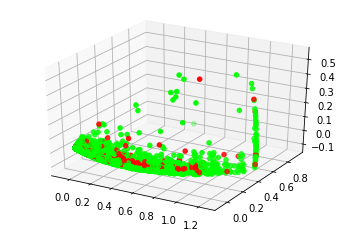

In [ ]:
#@title plot principal components of time domain features after filtering out bad windows
ds = filtered_combined_dataset(features_per_subj)
print("Plot of PCA with 3 dimensions using heartpy derived time domain features")
plot_pca(drop_bad_data(ds))

Plot of PCA with 3 dimensions using raw time domain data


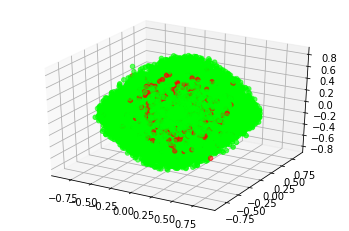

In [ ]:
#@title plot PCA for raw time domain windows
ds = filtered_combined_dataset(dataset)
print("Plot of PCA with 3 dimensions using raw time domain data")
plot_pca(ds)

# Binary classification of Stress vs Not 

We will use both raw windows data (first) and extracted time domain features to train the model.

We will try both randomly picked cross-validation and leave one subject out cross validation.
We will train an SVM with RBF kernel.

In [ ]:
#@title Data preparation for training using the two cross-validation methods of choice
def combine_dataset_with_group_id(dataset):
  training_data = None 
  X, y, groups = None, None, None
  subjects = list(dataset.keys())

  for s in dataset.keys():
    training_data = dataset[s]
    training_data = np.delete(training_data, np.where(training_data[:,-1] > 4), axis=0) 

    # Set stress label to 1 and rest to 0
    training_data[np.where(training_data[:,-1] < 2),-1] = 0 
    training_data[np.where(training_data[:,-1] > 2), -1] = 0
    training_data[np.where(training_data[:,-1] == 2),-1] = 1
    if X is None:
      X = training_data[:, :-1]
      y = training_data[:,-1]
      groups = np.repeat(subjects.index(s), training_data.shape[0])
    else:
      X = np.concatenate((X, training_data[:, :-1]))
      y = np.concatenate((y, training_data[:, -1]))
      groups = np.concatenate((groups, np.repeat(subjects.index(s), training_data.shape[0])))

  return X, y, groups

In [ ]:
#@title
from sklearn.model_selection import LeaveOneGroupOut, learning_curve, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.kernel_approximation import RBFSampler
from sklearn import metrics



In [ ]:
#@title Setting up train & test data with leave one group out cross validation

X, y, groups = combine_dataset_with_group_id(dataset)

logo = LeaveOneGroupOut()
train_idx, test_idx = next(logo.split(X, y, groups))
X_train, y_train, train_groups = X[train_idx], y[train_idx], groups[train_idx]
test_x, test_y = X[test_idx], y[test_idx]

In [ ]:
#@title Let's have a dummy classifer that always predicts `0` as that is the most likely outcome.
from sklearn.base import BaseEstimator

class BaseClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
base_clf = BaseClassifier()
base_cross_val_score = cross_val_score(base_clf, X_train, y_train, groups=train_groups, cv=cv, scoring="accuracy").mean()
print("Base (dummy) model accuracy when predicting only non-stress (0) labels is ", base_cross_val_score)

Base (dummy) model accuracy when predicting only non-stress (0) labels is  0.8798300934374728


In [ ]:
#@title Training a logistic regression model with SGD and running leave one out cross validation
cv = LeaveOneGroupOut()

clf_logreg = make_pipeline(RobustScaler(), SGDClassifier(loss="log", tol=1e-4, max_iter=10000))
#clf_logreg.fit(X_train, y_train)
y_pred_class_logreg = cross_val_predict(clf_logreg, X_train, y_train, groups=train_groups, cv = cv)
y_pred_prob_logreg = cross_val_predict(clf_logreg, X_train, y_train, groups=train_groups, cv = cv, method="predict_proba")
y_pred_prob_logreg_class1 = y_pred_prob_logreg[:, 1]


In [ ]:
#@title Training a SVM model with SGD and running leave one out cross validation

clf_SGD = make_pipeline(RobustScaler(), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))
#clf_SGD.fit(X_train, y_train)
# make class predictions for the validation set
y_pred_class_SGD = cross_val_predict(clf_SGD, X_train, y_train, groups=train_groups, cv = cv)
# predicted probabilities for class 1
y_pred_prob_SGD = cross_val_predict(clf_SGD, X_train, y_train, groups=train_groups, cv = cv, method="decision_function")

In [ ]:
#@title Training a SVM model with RBF kernel (50 components) and SGD, running leave one out cross validation

clf_rbf_SGD = make_pipeline(RobustScaler(), RBFSampler(gamma=.2, n_components=50), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))
#clf_rbf_SGD.fit(X_train, y_train)
# make class predictions for the validation set
y_pred_class_rbf_SGD = cross_val_predict(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv)
# predicted probabilities for class 1
y_pred_prob_rbf_SGD = cross_val_predict(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv, method="decision_function")



Given that we have an imbalanced dataset, log loss or accuracy isn't reflective of true model performance.
AUC_ROC is better as it helps figure out tradeoff between TPR and FPR where the latter is critical for the stress prediction problem.

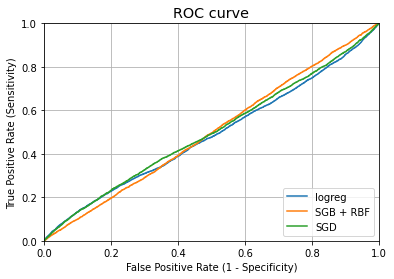

In [ ]:
#@title Plot ROC curves 
fpr_logreg, tpr_logreg, thresholds_logreg = metrics.roc_curve(y_train, y_pred_prob_logreg_class1)
fpr_SGD, tpr_SGD, thresholds_SGD = metrics.roc_curve(y_train, y_pred_prob_SGD)
fpr_rbf_SGD, tpr_rbf_SGD, thresholds_rbf_SGD = metrics.roc_curve(y_train, y_pred_prob_rbf_SGD)


plt.plot(fpr_logreg, tpr_logreg, label="logreg")
plt.plot(fpr_rbf_SGD, tpr_rbf_SGD, label="SGB + RBF")
plt.plot(fpr_SGD, tpr_SGD, label="SGD")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

In [ ]:
#@title Calculate AUC_ROC for the three models in consideration
roc_auc_logreg = cross_val_score(clf_logreg, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc').mean()
roc_auc_SGD = cross_val_score(clf_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc').mean()
roc_auc_rbf_SGD = cross_val_score(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc').mean()

roc_auc_logreg, roc_auc_SGD, roc_auc_rbf_SGD

(0.495293598176093, 0.5031647166040897, 0.5085588082624904)

In [ ]:
#@title calculate accuracies
acc_logreg = cross_val_score(clf_logreg, X_train, y_train, groups=train_groups, cv = cv, scoring = 'accuracy').mean()
acc_SGD = cross_val_score(clf_SGD, X_train, y_train, cv = cv, groups=train_groups,scoring = 'accuracy').mean()
acc_rbf_SGD = cross_val_score(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'accuracy').mean()

acc_logreg, acc_SGD, acc_rbf_SGD

(0.8316084282069495, 0.8122280607539885, 0.8798300934374728)

Accuracies of these models are lower than that of baseline.
Now let's try employing PCA and try to train a model.

[0.09497239 0.14047981 0.18491448 0.22822589 0.27113757 0.31364237
 0.35543079 0.39689108 0.43759634 0.47627164 0.51438237 0.54912389
 0.58221854 0.61210346 0.64099349 0.66735592 0.69351437 0.71580148
 0.73670312 0.75525382 0.77244709 0.78790671 0.80297909 0.81622785
 0.82814619 0.83908086 0.84948118 0.85937277 0.86835066 0.8767756
 0.88433555 0.89138207 0.89791817 0.90416603 0.9099778  0.91554042
 0.92084412 0.92587464 0.93069868 0.93518827 0.93941816 0.94338861
 0.94701628 0.95041253 0.95354393 0.9564698  0.95917816 0.9617673
 0.96411289 0.966298   0.96830378 0.97019093 0.97196498 0.97367553
 0.97528021 0.97674416 0.97813709 0.97939823 0.98063618 0.98179948
 0.98289536 0.98392813 0.98490865 0.98582917 0.98667652 0.98746863
 0.98823388 0.98892623 0.98957911 0.99019665 0.99078395 0.99135104
 0.99188285 0.99237103]


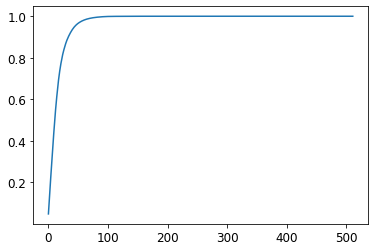

In [ ]:
#@title lets explore the size of the singular values to see how many dimensions we may need.
pca = PCA(n_components=500)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(np.cumsum(pca.explained_variance_ratio_)[1:75])

In [ ]:
#@title Calculate ROC_AUC
clf_pca_SGD = make_pipeline(RobustScaler(), PCA(n_components=75), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))
clf_rbf_pca_SGD = make_pipeline(RobustScaler(), PCA(n_components=75), RBFSampler(gamma=.2, n_components=50), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))

roc_auc_pca_SGD = cross_val_score(clf_pca_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc').mean()
roc_auc_rbf_pca_SGD = cross_val_score(clf_rbf_pca_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc').mean()

roc_auc_pca_SGD, roc_auc_rbf_pca_SGD

(0.5022075956943006, 0.4981948095252696)

PCA doesn't seem to help much as well. 
# Now let's try the heartpy derived features.

In [ ]:
#@title Prepare dataset with time domain features
X, y, groups = combine_dataset_with_group_id(features_per_subj)

logo = LeaveOneGroupOut()
train_idx, test_idx = next(logo.split(X, y, groups))
X_train, y_train, train_groups = X[train_idx], y[train_idx], groups[train_idx]
test_x, test_y = X[test_idx], y[test_idx]

def bad_indexes(data):
  indexes = []
  for r in range(data.shape[0]):
    if np.isnan(data[r]).sum() == 0 and data[r].sum() < np.inf:
      indexes.append(r)
  return indexes

good_indexes = bad_indexes(X_train)
X_train, y_train, train_groups = X_train[good_indexes], y_train[good_indexes], train_groups[good_indexes]
good_indexes = bad_indexes(test_x)
X_test, y_test = test_x[good_indexes], test_y[good_indexes]


In [ ]:
#@title
# Number of stressed labels in dataset
print("Train set has {0} stressed labels".format(y_train.sum()/y_train.shape[0]*100))

Train set has 11.971992653810835 stressed labels


In [ ]:
#@title AUC_ROC with time domain features
clf_logreg = make_pipeline(RobustScaler(), SGDClassifier(loss="log", tol=1e-4, max_iter=10000))
roc_auc_logreg = cross_val_score(clf_logreg, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc', verbose=2, n_jobs=-1).mean()
roc_auc_SGD = cross_val_score(clf_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc', verbose=2, n_jobs=-1).mean()
roc_auc_rbf_SGD = cross_val_score(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc', verbose=2, n_jobs=-1).mean()

roc_auc_logreg, roc_auc_SGD, roc_auc_rbf_SGD

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    4.5s finished


(0.49341380648013583, 0.4762611950082379, 0.7152756769780376)

SVM with RBF seems to fare well with heart beat features.
Let's look at it's accuracy to confirm it is above baseline

In [ ]:
#@title accuracy with RBF SVM model
acc_rbf_SGD = cross_val_score(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv, scoring = 'accuracy').mean()
acc_rbf_SGD

0.8794168358455922

Again the accuracy isn't great. Let's look at the confusion matrix.

In [ ]:
#@title
y_pred_class_rbf_SGD = cross_val_predict(clf_rbf_SGD, X_train, y_train, groups=train_groups, cv = cv)
rbf_sgd_matrix = metrics.confusion_matrix(y_train, y_pred_class_rbf_SGD)
print(rbf_sgd_matrix)

[[30676     0]
 [ 4172     0]]


Model is only predicting zeros which is why it is similar to baseline.

Now adding PCA to the mix to see if SVM can fare any better


In [ ]:
#@title
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[1.00000000e+00 3.37650224e-15 9.05127787e-20 2.10351159e-20
 5.98744274e-21 3.41866517e-21 1.82246104e-21 6.11796278e-22
 5.06485182e-22 9.32405979e-23 1.76107349e-25 5.09940958e-26
 2.54022415e-26]


There is only dominant dimension

In [ ]:
#@title AUC_ROC with PCA
clf_rbf_pca_SGD_heartpy = make_pipeline(RobustScaler(), PCA(n_components=3), RBFSampler(gamma=.2, n_components=50), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))

roc_auc_rbf_pca_SGD = cross_val_score(clf_rbf_pca_SGD_heartpy, X_train, y_train, groups=train_groups, cv = cv, scoring = 'roc_auc').mean()

roc_auc_rbf_pca_SGD

0.7015659382331586

# Classification based on Frequency Domain Features

Let's convert the time domain signals to frequency domain via a fourier transform and then see if the stress and non-stress labels can be separated any better than in time domain.

We will plot output of PCA as well to see if the frequency domain distribution is any different from the time domain.

In [ ]:
#@title Load the raw wesad dataset without any windowing, process it and store it to gdrive
%skip True
wesad_no_windows_df = pd.read_csv('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/combined.gz')
dataset_no_windows = {}
for subj in wesad_no_windows_df.subject.unique():
  df = wesad_no_windows_df[wesad_no_windows_df.subject == subj]
  bvp = df['bvp'].to_numpy()
  labels = df['label']
  dataset_no_windows[subj] = (bvp, labels)
%reset wesad_no_windows_df
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/no-windows.pkl', 'wb') as fp:
    pickle.dump(dataset_no_windows, fp, protocol=pickle.HIGHEST_PROTOCOL)  


In [ ]:
#@title Load non windowed data from gdrive
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/no-windows.pkl', 'rb') as fp:
    dataset_no_windows = pickle.load(fp)  


In [ ]:
#@title Compute short time fourier transform and labels for each of those windows and store the result on gdrive
%skip True
from scipy import signal
freq_features = {}
window_len=8 #s
freq = 64 #hz
overlap = 6 #s

def get_window_labels(labels):
    start_idx = 0
    end_idx = window_len*freq
    stride_len = (window_len-overlap)*freq
    result_data = []
    while end_idx <= len(labels):
        unique_labels, counts = np.unique(labels[start_idx:end_idx], return_counts=True)
        desired_label = unique_labels[np.argmax(counts)]
        result_data.append(desired_label)
        start_idx += stride_len
        end_idx += stride_len
    return np.squeeze(np.array(result_data))

for s in dataset_no_windows.keys():
  bvp = dataset_no_windows[s][0]
  labels = dataset_no_windows[s][1]
  # Filter to desired frequency range
  sos = signal.butter(4, [0.7, 3.5], 'bandpass', fs=freq, output='sos')
  filtered = signal.sosfilt(sos, bvp)
  f, t, Zxx = signal.stft(filtered, fs=freq, nperseg=window_len*freq, noverlap=overlap*freq, boundary=None, padded=False)
  labels = get_window_labels(labels)
  freq_features[s] = (f, t, Zxx, labels)

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/freq-domain.pkl', 'wb') as fp:
    pickle.dump(freq_features, fp, protocol=pickle.HIGHEST_PROTOCOL)  

In [ ]:
#@title Load frequency domain features already available on gdrive
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/freq-domain.pkl', 'rb') as fp:
    freq_features = pickle.load(fp)  

aggregate the data to make it consumable by sklearn APIs


In [ ]:
#@title 
def combine_freq_domain_dataset_with_group_id(dataset):
  training_data = None 
  X, y, groups = None, None, None
  subjects = list(dataset.keys())

  for s in dataset.keys():
    training_data = np.array(dataset[s][2]).T # FFT data
    labels = np.copy(dataset[s][3])
    drop_indexes = np.where(labels > 4)
    training_data = np.delete(training_data, drop_indexes, axis=0) 
    labels = np.delete(labels, drop_indexes, axis=0)
    # Set stress label to 1 and rest to 0
    labels[np.where(labels < 2)] = 0 
    labels[np.where(labels > 2)] = 0
    labels[np.where(labels == 2)] = 1
    if X is None:
      X = training_data
      y = labels
      groups = np.repeat(subjects.index(s), training_data.shape[0])
    else:
      X = np.concatenate((X, training_data))
      y = np.concatenate((y, labels))
      groups = np.concatenate((groups, np.repeat(subjects.index(s), training_data.shape[0])))
  return X, y, groups


In [ ]:
#@title Setting up train & test data with leave one group out cross validation

X, y, groups = combine_freq_domain_dataset_with_group_id(freq_features)
X = 20*np.log10(np.abs(X))
logo = LeaveOneGroupOut()
train_idx, test_idx = next(logo.split(X, y, groups))
X_train, y_train, train_groups = X[train_idx], y[train_idx], groups[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

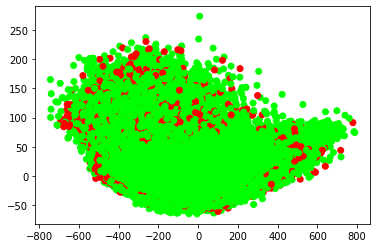

In [ ]:
#@title lets explore the PCA output in 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_train)
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 2))
red = np.array([1,0,0,1])
green = np.array([0, 1, 0, 1])
newcolors[0,:] = green
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)
plt.scatter(pca_data[:,0], pca_data[:,1], c=y_train, cmap=newcmp)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
pca = PCA(n_components=0.99)
pca_data = pca.fit_transform(X_train)
X_embedded = TSNE(n_components=2).fit_transform(pca_data)
plt.scatter(X_embedded[0], X_embedded[1])

KeyboardInterrupt: ignored

In [ ]:
import gc
gc.collect()

323

In [ ]:
cv = LeaveOneGroupOut()
clf_rbf_pca_SGD_freq = make_pipeline(RobustScaler(), RBFSampler(gamma=.2, n_components=50), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))

roc_auc_rbf_pca_SGD = cross_val_score(clf_rbf_pca_SGD_freq, X_train_res, y_train_res, groups=train_groups_res, cv = cv, scoring = 'roc_auc', verbose=2).mean()

roc_auc_rbf_pca_SGD

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  33.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.1s remaining:    0.0s


[CV] ................................................. , total=  30.5s
[CV]  ................................................................
[CV] ................................................. , total=  30.1s
[CV]  ................................................................
[CV] ................................................. , total=  31.6s
[CV]  ................................................................
[CV] ................................................. , total=  30.4s
[CV]  ................................................................
[CV] ................................................. , total=  30.6s
[CV]  ................................................................
[CV] ................................................. , total=  29.7s
[CV]  ................................................................
[CV] ................................................. , total=  30.9s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  7.2min finished


0.5323857037292826

In [ ]:
from imblearn.over_sampling import SMOTE

X_train_res, y_train_res, train_groups_res = None, None, None
subjects = np.unique(train_groups)
for g in np.unique(train_groups):
  idx = np.where(train_groups == g)
  sm = SMOTE(random_state=2)
  x, y = sm.fit_sample(X_train[idx], y_train[idx])
  if X_train_res is None:
    X_train_res, y_train_res = x, y
    train_groups_res = np.repeat(g, x.shape[0])
  else:
    X_train_res = np.concatenate((X_train_res, x), axis=0)
    y_train_res = np.concatenate((y_train_res, y), axis=0)
    train_groups_res = np.concatenate((train_groups_res, np.repeat(g, x.shape[0])), axis=0)
  

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
from sklearn.kernel_approximation import Nystroem
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)
data_transformed = feature_map_nystroem.fit_transform(X_train_res)
clf = SGDClassifier(tol=1e-4, max_iter=10000)
clf.fit(data_transformed, y_train_res)
clf.score(data_transformed, y_train_res)

0.5

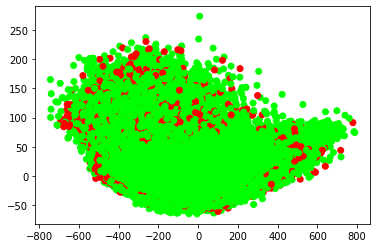

In [ ]:
#@title lets explore the size of the singular values to see how many dimensions we may need.
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_train)
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 2))
red = np.array([1,0,0,1])
green = np.array([0, 1, 0, 1])
newcolors[0,:] = green
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)
plt.scatter(pca_data[:,0], pca_data[:,1], c=y_train, cmap=newcmp)
plt.show()

In [ ]:
cv = LeaveOneGroupOut()
clf_rbf_pca_SGD_freq = make_pipeline(RobustScaler(), RBFSampler(gamma=.2, n_components=50), SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000))

roc_auc_rbf_pca_SGD = cross_val_score(clf_rbf_pca_SGD_freq, X_train_res, y_train_res, groups=train_groups_res, cv = cv, scoring = 'roc_auc', verbose=2).mean()

roc_auc_rbf_pca_SGD

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  30.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s


[CV] ................................................. , total=  28.6s
[CV]  ................................................................
[CV] ................................................. , total=  28.1s
[CV]  ................................................................
[CV] ................................................. , total=  28.8s
[CV]  ................................................................
[CV] ................................................. , total=  29.2s
[CV]  ................................................................
[CV] ................................................. , total=  28.4s
[CV]  ................................................................
[CV] ................................................. , total=  26.0s
[CV]  ................................................................
[CV] ................................................. , total=  26.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  6.4min finished


0.5390323469959613

In [ ]:
output = stats.describe(X_train, axis=0)


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
pca_output = PCA(n_components=0.99).fit_transform(X_train_res)
clf = SGDClassifier(loss="hinge", tol=1e-4, max_iter=10000)
clf = QuadraticDiscriminantAnalysis()
clf.fit(pca_output, y_train_res)

# Ignore cells from here

In [ ]:
#@title utility method to plot learning curve
def plot_learning_curve(train_sizes, train_scores, test_scores, score="Negative Log Loss"):
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fig = plt.figure(100, figsize=(20,10))
  ax = plt.axes()
  ax.set_xlabel("Training examples")
  ax.set_ylabel(score)
  ax.grid()
  ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
  ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
  ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training {}".format(score))
  ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation {}".format(score))
  ax.legend(loc="best")
  ax.set_title("Learning curve showing training & test set {} measured against varying dataset sizes using leave one group out cross validation".format(score), fontsize=15)
  plt.show()

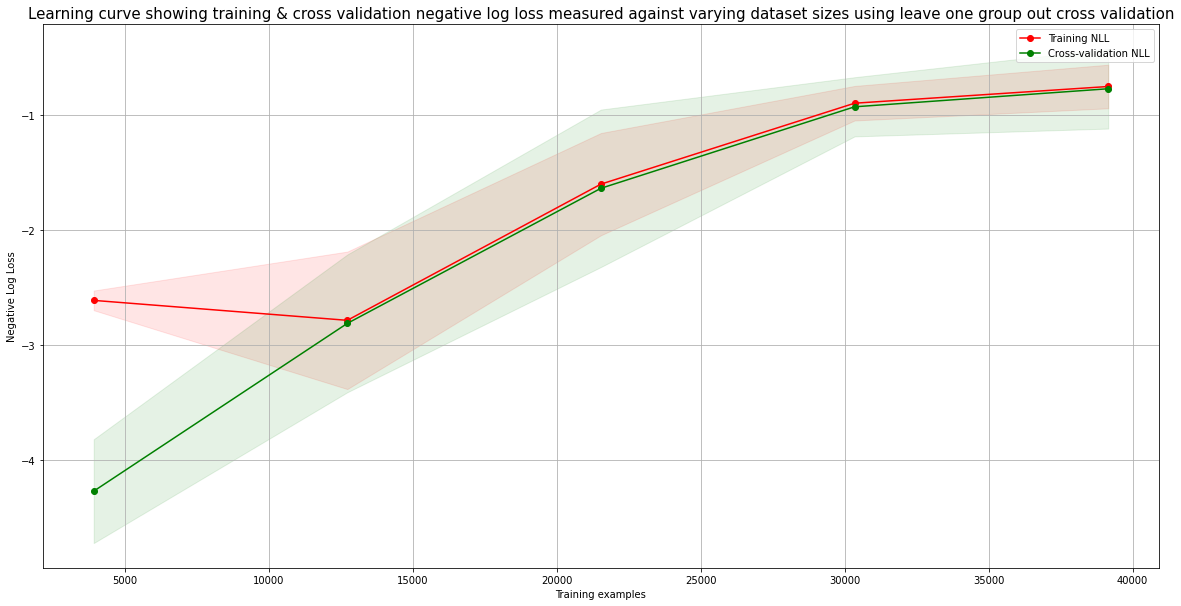

In [ ]:
model = make_pipeline(RobustScaler(), SGDClassifier(loss="log", tol=1e-4, max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(model, 
                                                        train_x, 
                                                        y, 
                                                        groups=groups, 
                                                        train_sizes=np.linspace(0.1, 1, 10),
                                                        scoring="negative_log_loss", 
                                                        random_state=0,
                                                        cv=LeaveOneGroupOut())
plot_learning_curve(train_sizes, train_scores, test_scores, score="Negative Log Loss")

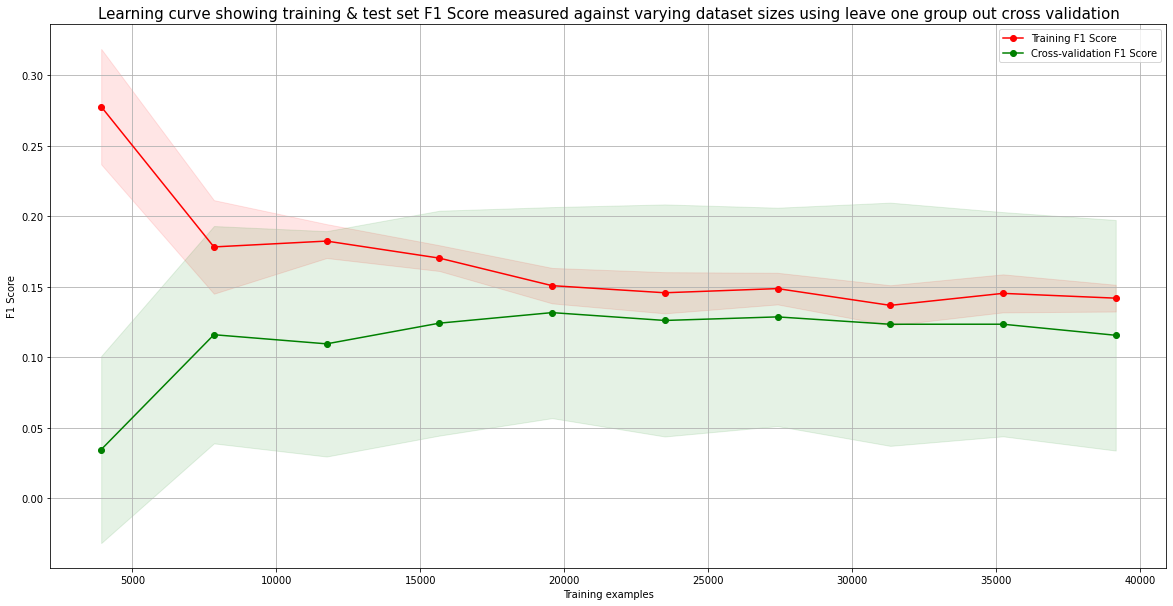

In [ ]:
model = make_pipeline(RobustScaler(), SGDClassifier(loss="log", tol=1e-4, max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(model, 
                                                        train_x, 
                                                        y, 
                                                        groups=groups, 
                                                        train_sizes=np.linspace(0.1, 1, 10),
                                                        scoring="f1", 
                                                        random_state=0,
                                                        cv=LeaveOneGroupOut())
plot_learning_curve(train_sizes, train_scores, test_scores, score="F1 Score")

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


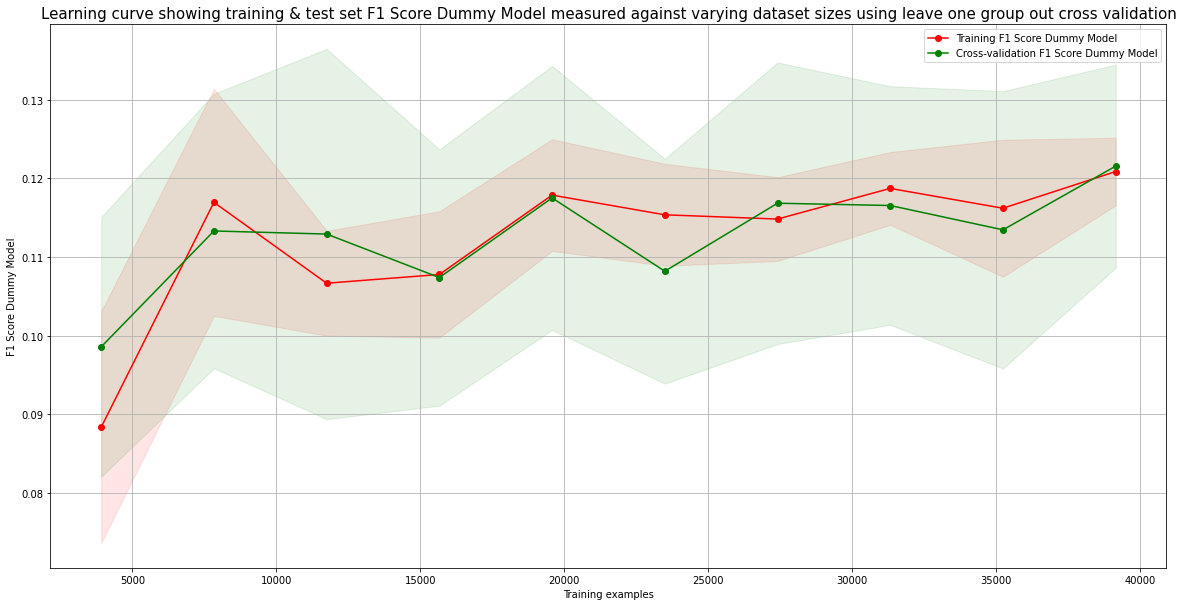

In [ ]:
from sklearn.dummy import DummyClassifier
train_sizes, train_scores, test_scores = learning_curve(DummyClassifier(), 
                                                        X, 
                                                        y, 
                                                        groups=groups, 
                                                        train_sizes=np.linspace(0.1, 1, 10),
                                                        scoring="f1", 
                                                        random_state=0,
                                                        cv=LeaveOneGroupOut())
plot_learning_curve(train_sizes, train_scores, test_scores, score="F1 Score Dummy Classifier")

In [ ]:
from sklearn.model_selection import GridSearchCV
X, y, groups = combine_dataset_with_group_id(dataset)

logo = LeaveOneGroupOut()

#transformer = RobustScaler().fit(X)
#train_x = transformer.transform(X)
model = make_pipeline( RobustScaler(), SGDClassifier(loss="log", tol=1e-4, n_jobs=-1, early_stopping=True))
parameters = {'sgdclassifier__alpha':np.linspace(0.0001,0.1,20), 'sgdclassifier__penalty':['l2', 'l1'], 'sgdclassifier__max_iter':[1000, 10000, 50000]}
clf = GridSearchCV(model, parameters, n_jobs=-1, scoring="f1", cv=logo, verbose=2)
clf.fit(X, y, groups)
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/grid_search_lr.pkl', 'wb') as fp:
    pickle.dump(clf, fp, protocol=pickle.HIGHEST_PROTOCOL)


Fitting 15 folds for each of 120 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 38.3min finished


In [ ]:
clf.best_estimator_.decision_function(X)

array([ 80.28166645,  62.12190227, -98.47928184, ..., -66.44377199,
       -54.18323335, -49.18265875])

In [ ]:
#@title An SVM model with RBF Kernel, holdout cross-validation
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn import svm
def rbf_svm_model_holdout(dataset, nd=400, filter_bad_data=False):
  train_x, train_y, test_x, test_y = get_train_test_data_holdout(dataset,filter_bad_data=filter_bad_data)
  feature_map_fourier = RBFSampler(gamma=.2, n_components=nd)
  svm_pipeline = Pipeline([('robust_scaler', preprocessing.RobustScaler()), ('rbf_kernel', feature_map_fourier), ("sgd", SGDClassifier(max_iter=50000, tol=1e-3))])
  svm_pipeline.fit(train_x, train_y)
  accuracy = svm_pipeline.score(test_x, test_y)
  print("Test Accuracy {:2.2f}%".format(accuracy*100))
  return accuracy

In [ ]:
#@title An SVM model with RBF Kernel & leave one out cross-validation
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn import svm
def rbf_svm_model_leave_one_out(dataset, nd=400, filter_bad_data=False):
  data_samples = get_train_test_data_leave_one_out(dataset,filter_bad_data=filter_bad_data)
  num_dimensions = 400
  feature_map_fourier = RBFSampler(gamma=.2,  n_components=num_dimensions)
  accuracies = []
  for train_x, train_y, test_x, test_y in data_samples:
    svm_pipeline = Pipeline([('robust_scaler', preprocessing.Normalizer()), ('rbf_kernel', feature_map_fourier), ("sgd", SGDClassifier(max_iter=50000, tol=1e-3))])
    svm_pipeline.fit(train_x, train_y)
    accuracies.append(svm_pipeline.score(test_x, test_y))
  print("Average test Accuracy {:2.2f}%".format(np.mean(accuracies)*100))
  return accuracies

In [ ]:
#@title Train & Output model accuracies
print("Training SVM Classifier with RBF kernel and 400 dimensions and holdout cross-validation")
raw_td_holdout_accuracy = rbf_svm_model_holdout(dataset)
print("Training SVM Classifier with RBF kernel and 400 dimensions and leave one subject out cross-validation")
leave_out_td_holdout_accuracy = rbf_svm_model_leave_one_out(dataset)
print("Training SVM Classifier with RBF kernel and 400 dimensions and holdout cross-validation using heartypy features")
heartpy_td_holdout_accuracy = rbf_svm_model_holdout(features_per_subj, filter_bad_data=True)
print("Training SVM Classifier with RBF kernel and 400 dimensions and leave one subject out cross-validation using heartypy features")
leave_out_heartpy_td_holdout_accuracy = rbf_svm_model_leave_one_out(features_per_subj, filter_bad_data=True)

Training SVM Classifier with RBF kernel and 400 dimensions and holdout cross-validation
Test Accuracy 88.15%
Training SVM Classifier with RBF kernel and 400 dimensions and leave one subject out cross-validation
Average test Accuracy 88.41%
Training SVM Classifier with RBF kernel and 400 dimensions and holdout cross-validation using heartypy features
Test Accuracy 89.01%
Training SVM Classifier with RBF kernel and 400 dimensions and leave one subject out cross-validation using heartypy features
Average test Accuracy 88.32%


# Let's try some deep learning models.
For deep neural nets we could use more data to train them.
Let's load the PPG-Dalia dataset as well to learn lower dimensional representations of the bvp signals.
We will then attempt to use those representations to predict stress and heart rate as well to ensure the representations generalize well.

In [ ]:
#@title Let's load up the ppg-dalia dataset as well